# 뉴스 카테고리 다중분류 [프로젝트]

- Voca size를 변경하면서 결과값이 달라지는 부분을 시각화하는 프로젝트


## 결론
- vocasize와 정확도간의 관계는 선형이 아니다.
- voca_size가 올라갈수록 tf-idf의 희소벡터가 늘어나므로 정확도가 더 안좋아지는 모델도 있음
  
## 모델, voca_size별 accuary 결과
### NB
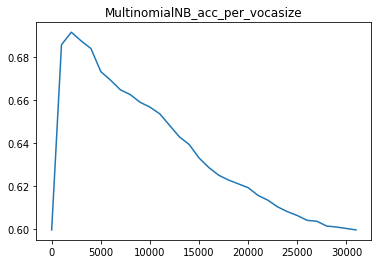

### ComplementNB
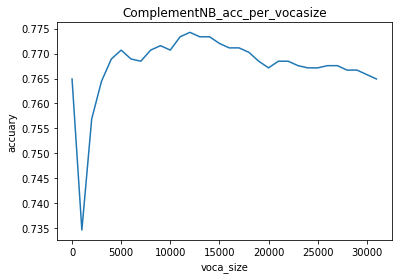

### DecisionTreeClassifier
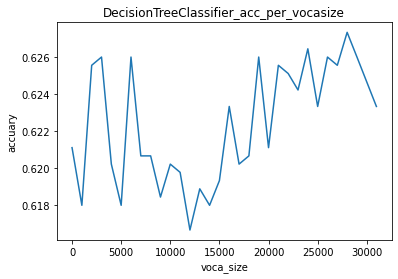

### LinearSVC
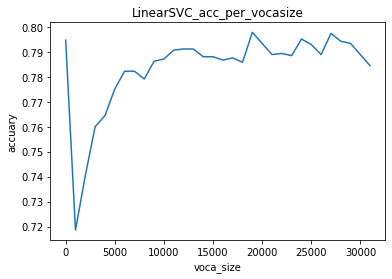

### LogisticRegression 
- 오래걸려서 다음 6개의 voca_size에 대해서만 진행했다 [1000, 5000, 10000, 15000, 20000,30979]
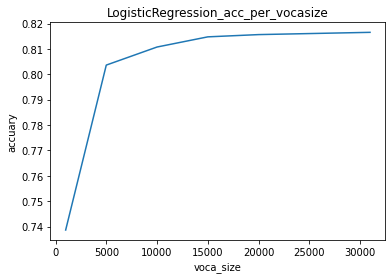

### Voting
- 여기도 하는데 한시간 이상 걸렸다
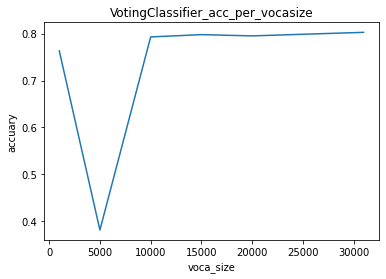




### 브레인 스토밍
- 각 모델별 학습에 걸리는 시간이 제각각에 너무 오래걸렸다.
- 이때 더 많은 실험을 할수있는 방법이있을까?
- 모델별로 시간과 정확도를 분석해보자
    - NB, ComplementNB - 77% 등은 학습에 오랜시간이 걸리지않았다 
    - LogisticRegression - 한번에 10분정도 소요 - 하지만 결과가 81%로 가장좋았음
    - LinearSVC - 3분정도 - 77%
    - DecisionTree - 바로 학습완료 - 62%
    - GradientBoostingClassifier - 15분 - 76%
- 시간이 덜 걸리는 모델을 통해서 자동화를 완성하고 점심시간을 이용해서 시간이 오래걸리는 로지스틱을 돌려봤다
- 이후에 오늘 배운 내용을 정리하면서 나머지 실험도 진행할예정

# 회고

진행하다보니 결정트리나 랜덤포레스트는 뎁스와 에스터메이트가 변할때 성능이 계속 변했다., 이렇게 여러모델을 비교할때 각각의 모델의 최적의 하이퍼 파라미터를 결정하기 위해서는 어떤 실험 설계를 진행해야할지..

 voca_size가 0일때도 점수가 나오는걸 보면 신기하다
 
 다른 머신러닝 모델을 학습시키느라 막판에 딥러닝 기반 모델의 디버깅을 하는 시간이 부족했다. 
 하하
 
 그리고 accuary와 f1-score를 같이 plot했으면 더 이쁜 실험 결과가 나왔을것같다.

In [43]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 벡터화용 라이브러리
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# 머신러닝 라이브러리
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산

# 자동화 코드
- 모델과 voca_size list input을 넣어서 한번에 결과를 얻는 코드
- input = voca_size , model

In [33]:
# voca_size 를 input으로 받아서 DTM 전처리이후 model 학습 이후 predict데이터까지 만들어주는 코드

def compare_voca_s(model, voca_size_list):
    model_result = []
    for voca_size in voca_size_list:
        print('voca_size : ', voca_size , '')
        # 데이터 불러오기 - index2word 설정해주기, 시작토큰등 설정
        (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=voca_size, test_split=0.2)
        word_index = reuters.get_word_index(path="reuters_word_index.json")
        index_to_word = { index+3 : word for word, index in word_index.items() }
        for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
            index_to_word[index]=token
            
        # 텍스트 데이터로 변환
        decoded = []
        for i in range(len(x_train)):
            t = ' '.join([index_to_word[index] for index in x_train[i]])
            decoded.append(t)
        x_train = decoded
        decoded = []
        for i in range(len(x_test)):
            t = ' '.join([index_to_word[index] for index in x_test[i]])
            decoded.append(t)
        x_test = decoded
        
        # 벡터화 진행
        dtmvector = CountVectorizer()
        tfidf_transformer = TfidfTransformer()
        
        x_train_dtm = dtmvector.fit_transform(x_train)
        x_test_dtm = dtmvector.transform(x_test)
        
        x_train_tfidf = tfidf_transformer.fit_transform(x_train_dtm)
        x_test_tfidf = tfidf_transformer.transform(x_test_dtm)
        
        model.fit(x_train_tfidf, y_train)
        
        predicted = model.predict(x_test_tfidf)
        score = accuracy_score(y_test, predicted)
        model_result.append(score)
    return model_result

def mk_plot(voca_size_list, predict_acc_list):
    plt.plot(voca_size_list,predict_acc_list)
        

# 실행코드

In [46]:
# 마지막 부분을 None으로 넣으면 Plot에서 안보이는 문제가있다
input_voca_size = list(range(0, 29001, 1000)) + [30979]
mini_input_voca_size = [1000, 5000, 10000, 15000, 20000,30979]

# 나이브 베이즈
model_NB = MultinomialNB()
cb = ComplementNB()
# 결정트리
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
# 로지스틱
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
# 선형 SV
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
# 보팅 모델
clf1 = LogisticRegression(penalty='l2', random_state=1)
clf2 = GradientBoostingClassifier(random_state=1)
clf3 = ComplementNB()
voting_classifier =  VotingClassifier(estimators=[
        ('lr', clf1), ('GBC', clf2), ('CNB', clf3)], voting='soft')


predict_acc_list = compare_voca_s(voting_classifier,mini_input_voca_size)


voca_size :  1000 


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


voca_size :  5000 


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


voca_size :  10000 


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


voca_size :  15000 


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


voca_size :  20000 


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


voca_size :  30979 


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(0, 0.5, 'accuary')

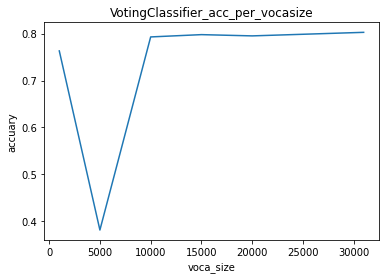

In [48]:
plt.plot(mini_input_voca_size,predict_acc_list)
plt.title('VotingClassifier_acc_per_vocasize')
plt.xlabel('voca_size')
plt.ylabel('accuary')

# 딥러닝을 사용한 모델

In [52]:
import tensorflow as tf

def compare_voca_s_for_lstm(voca_size_list):
    model_result = []
    for voca_size in voca_size_list:
        print('voca_size : ', voca_size , '')
        # 데이터 불러오기 - index2word 설정해주기, 시작토큰등 설정
        (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=voca_size, test_split=0.2)
        word_index = reuters.get_word_index(path="reuters_word_index.json")
        index_to_word = { index+3 : word for word, index in word_index.items() }
        for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
            index_to_word[index]=token
            
        # 텍스트 데이터로 변환
        decoded = []
        for i in range(len(x_train)):
            t = ' '.join([index_to_word[index] for index in x_train[i]])
            decoded.append(t)
        x_train = decoded
        decoded = []
        for i in range(len(x_test)):
            t = ' '.join([index_to_word[index] for index in x_test[i]])
            decoded.append(t)
        x_test = decoded
        
        # 벡터화 진행
        dtmvector = CountVectorizer()
        tfidf_transformer = TfidfTransformer()
        
        x_train_dtm = dtmvector.fit_transform(x_train)
        x_test_dtm = dtmvector.transform(x_test)
        
        x_train_tfidf = tfidf_transformer.fit_transform(x_train_dtm)
        x_test_tfidf = tfidf_transformer.transform(x_test_dtm)
        
        # 모델 정의 
        word_vector_dim = 512 
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Embedding(voca_size, word_vector_dim, input_shape=(None,)))
        model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
        model.add(tf.keras.layers.Dense(8, activation='relu'))
        model.add(tf.keras.layers.Dense(46, activation='softmax'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        
        model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              
        epochs=20
        
        model.fit(x_train_tfidf, y_train)
        
        predicted = model.predict(x_test_tfidf)
        score = accuracy_score(y_test, predicted)
        model_result.append(score)
    return model_result

compare_voca_s_for_lstm(mini_input_voca_size)

voca_size :  1000 


InvalidArgumentError: indices[1] = [0,919] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SerializeManySparse]

# 이 아래부터는 노드 코드 notebook입니다.

# 데이터 불러오기
- 데이터가 이미 정수형으로 인코딩되어있다
- 이를 다시 텍스트 형태로 바꾸는 작업을 진행

- 여기서 만들어진 x_train과 x_test를 사용해서 벡터화를 진행한다

In [13]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

In [14]:
print(x_train[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [15]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

In [16]:
index_to_word = { index+3 : word for word, index in word_index.items() }

In [19]:
len(word_index)

30979

In [ ]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

In [ ]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

print(len(x_test))
print(len(x_train))

In [ ]:
print('train decode result : ', x_train[0], '\n')

print('train decode result : ', x_test[0])

# DTM 생성, tf-idf 생성

- train과 test의 단어장의 개수가 달라도 상관이 없는걸까?
    - 잘보면 test를 바꿔줄때는 fit_transform이 아니라 그냥 transform이다

In [ ]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
x_test_dtm = dtmvector.transform(x_test)
print(x_train_dtm.shape)
print(x_test_dtm.shape)

In [ ]:
tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_dtm)
x_test_tfidf = tfidf_transformer.transform(x_test_dtm)
print(x_train_tfidf.shape)
print(x_test_tfidf.shape)

# 모델 생성 및 학습

In [ ]:
model_NB = MultinomialNB()
model_NB.fit(x_train_tfidf, y_train)
predicted = model_NB.predict(x_test_tfidf) #테스트 데이터에 대한 예측

In [ ]:
predicted

In [ ]:
accuracy_score(y_test, predicted)